In [ ]:
qfrom google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install plot-keras-history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9455 sha256=0e25170893402af4e57f9b013973c7196320334462d3bd50d0503075b3acfafd
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321865 sha256=e51aaf43c19ba94691cd6e59e458fe59c00150f550b6ec38b8d68ad2c32627bb
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=0448e622be9dcfe56f5dd220f3d103a70ff57184864d15e377463946160353ad
  Stored in directo

In [ ]:
import os
import numpy as np
import pandas as pd
import shutil
from functools import partial
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import cv2

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, BatchNormalization, Input, Dropout, Conv2D, Permute
from tensorflow.keras import Model
import albumentations as A
from plot_keras_history import show_history, plot_history
from transformers import TFViTModel
AUTOTUNE = tf.data.experimental.AUTOTUNE
%matplotlib inline


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [ ]:
# ALL_CLASSES = ['anger', 'contempt', 'disgust', 'fear',
#            'happy', 'neutral', 'sad', 'surprised']
CLASSES = ['fear', 'happy', 'neutral', 'sad', 'surprised'] # delete contempt, disgust and anger
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8 * 2
LEARNING_RATE = 1e-3
EPOCHS = 60

In [ ]:
import zipfile
import os
from tqdm import tqdm

# Set the paths
zip_file_path = '/content/drive/MyDrive/aug_emotion.zip'  # Update with your actual path
extracted_folder_path = '/content/AUG_DATASET'  # Update with your desired path

# Create the folder for extracted data
os.makedirs(extracted_folder_path, exist_ok=True)

# Unzip the file with progress bar
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Get the total number of files to extract
    total_files = len(zip_ref.infolist())

    # Use tqdm for progress bar
    for file_info in tqdm(zip_ref.infolist(), desc="Extracting", unit="file", total=total_files):
        zip_ref.extract(file_info, extracted_folder_path)


Extracting: 100%|██████████| 944/944 [00:11<00:00, 81.42file/s] 


## 1. Data preparation

In [ ]:
path = '/content/AUG_DATASET/aug_emotion'

In [ ]:
dataset_train = tf.keras.utils.image_dataset_from_directory(
    directory=path,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=1,
    validation_split=None,
)

dataset_val = tf.keras.utils.image_dataset_from_directory(
    directory=path,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=1,
    validation_split=None,
)

Found 939 files belonging to 5 classes.
Found 939 files belonging to 5 classes.


In [ ]:
@tf.function
def image_scale(image, label):
    image /= 255.
    return image, label

In [ ]:
dataset_train = dataset_train.map(image_scale,
                                  num_parallel_calls=AUTOTUNE)
dataset_val = dataset_val.map(image_scale,
                                  num_parallel_calls=AUTOTUNE)

In [ ]:
transforms = A.Compose([
    A.CropAndPad(percent=0.17, p=0.2), A.HorizontalFlip(p=0.4), A.OneOf([A.MotionBlur(p=.2),A.MedianBlur(blur_limit=3, p=0.1), A.Blur(blur_limit=3, p=0.1),], p=0.3),A.CoarseDropout(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.27, rotate_limit=10, p=0.3),
    A.OneOf([A.Sharpen(),A.Emboss(),A.RandomBrightnessContrast(),], p=0.3),])

In [ ]:
def aug_fn(image):
    data = {'image': image}
    image = transforms(**data)['image']
    return image

input_prepoccess_f = lambda image, label: (2. * image - 1., label)

@tf.function
def image_preprocessing(image, label, scale=True):
    image = tf.numpy_function(func=aug_fn, inp=[image],
                              Tout=tf.float32)
    image.set_shape((*IMAGE_SIZE, 3))
    image = tf.clip_by_value(image, clip_value_min=0.,
                               clip_value_max=1.)
    # mobilenet_v2 preprocess of input
    if scale:
        image = 2. * image - 1.
    return image, label

In [ ]:
dataset_train_ = dataset_train.map(partial(image_preprocessing, scale=False), num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = 8,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
buffer_size = 18
dataset_train_m = dataset_train.map(image_preprocessing, num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_val_m = dataset_val.map(input_prepoccess_f, num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 2. Model training

In [ ]:
!pip install keras-utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=a5a62a4c35e4f26b7102adf5c1343a51ec224d887cdd9adc7cce0326b1095d2b
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras-utils


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D
from plot_keras_history import plot_history

In [ ]:
model = Sequential()
model.add(Input(shape=IMAGE_SIZE + (3,)))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=IMAGE_SIZE + (3,)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 110, 110, 64)      256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     7

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

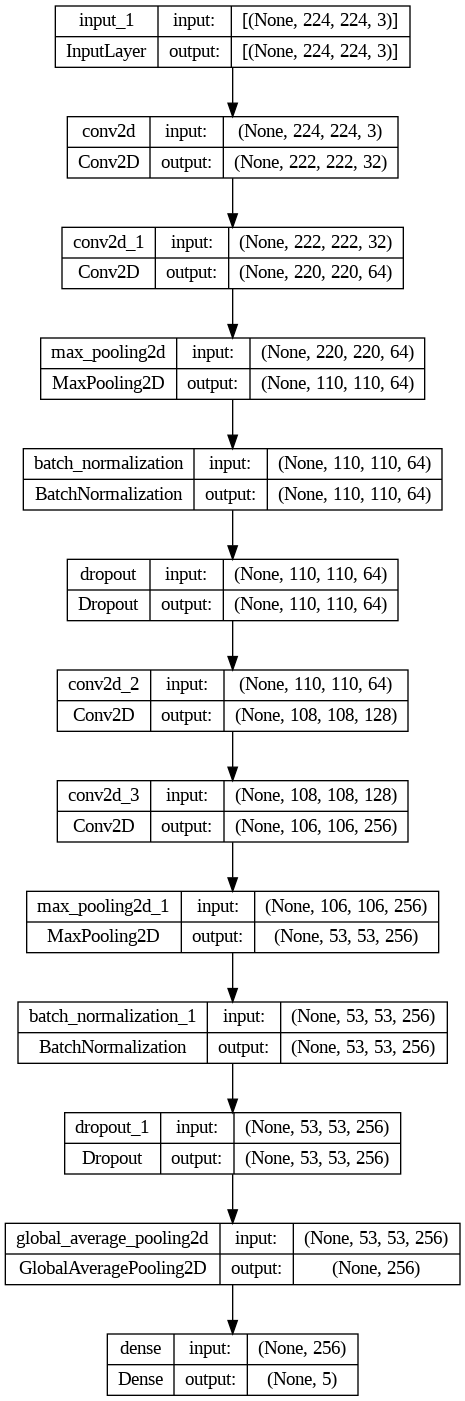

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [ ]:
# Train the model
history = model.fit(dataset_train_m, epochs=100, validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/100
59/59 [==============================] - 124s 705ms/step - loss: 1.7764 - categorical_accuracy: 0.2055 - top_k_categorical_accuracy: 0.3983 - val_loss: 1.6390 - val_categorical_accuracy: 0.2002 - val_top_k_categorical_accuracy: 0.3983 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 81s 772ms/step - loss: 1.6223 - categorical_accuracy: 0.2023 - top_k_categorical_accuracy: 0.4271 - val_loss: 1.6617 - val_categorical_accuracy: 0.2002 - val_top_k_categorical_accuracy: 0.3972 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 65s 642ms/step - loss: 1.6235 - categorical_accuracy: 0.2204 - top_k_categorical_accuracy: 0.4228 - val_loss: 1.6691 - val_categorical_accuracy: 0.2023 - val_top_k_categorical_accuracy: 0.3983 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 63s 664ms/step - loss: 1.6266 - categorical_accuracy: 0.2311 - top_k_categorical_accuracy: 0.4185 - val_loss: 1.6483 - val_categorical_accuracy: 0.1981 - val_top_k_categ

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Categorical accuracy'}, xlabel='Epochs', ylabel='Categorical accuracy'>,
        <Axes: title={'center': 'Top k Categorical accuracy'}, xlabel='Epochs', ylabel='Top k Categorical accuracy'>,
        <Axes: title={'center': 'Learning rate'}, xlabel='Epochs', ylabel='Learning rate'>],
       dtype=object))

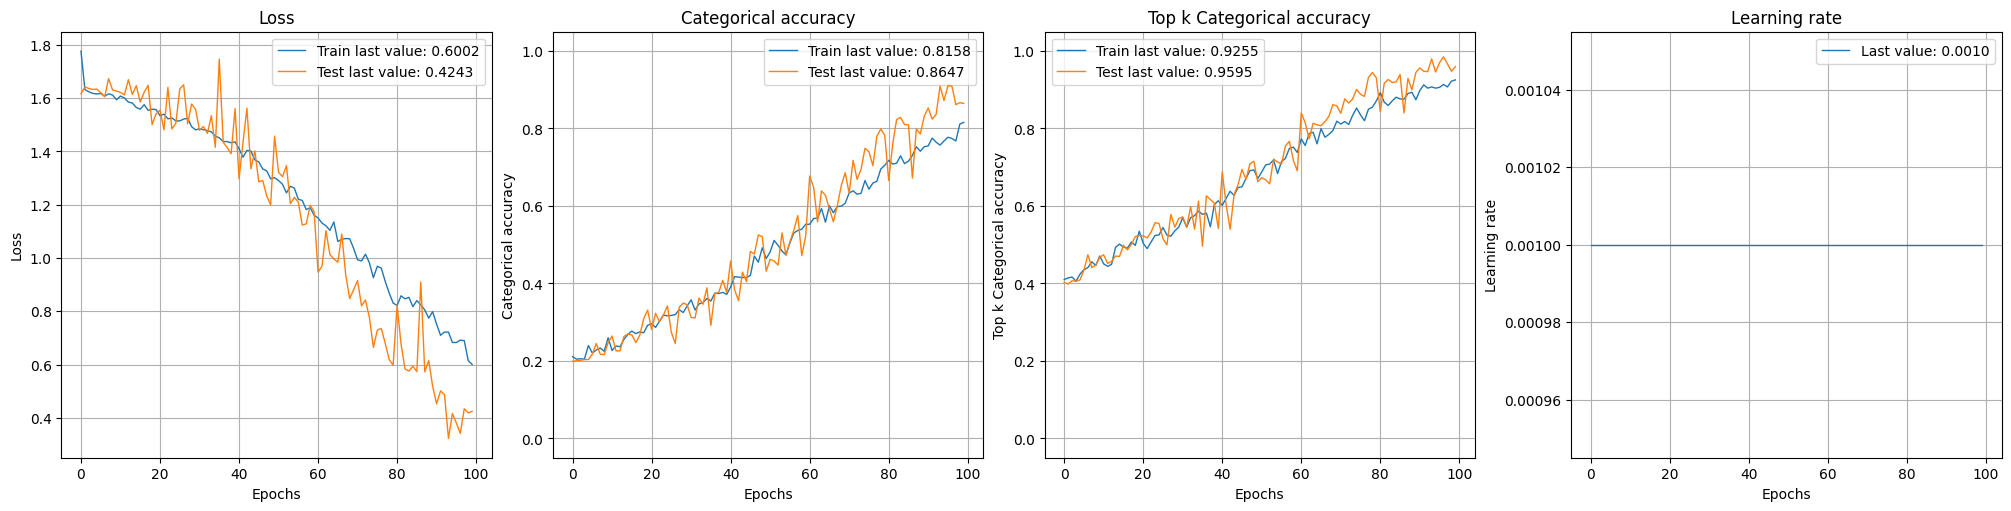

In [ ]:
plot_history(history, path="history_cnn.png")

### VGG19

In [ ]:
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
backbone = keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=None,
    #include_preprocessing=False,
)
backbone.trainable = False
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_cls = Model(inputs, outputs, name='facial_exp_cls') # 41 - 50 6 classes B2 32, 0.001, 128
model_cls.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "facial_exp_cls"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                     

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model_cls.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

In [ ]:
history = model_cls.fit(dataset_train_m, epochs=100,
          validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

Epoch 1/100
59/59 [==============================] - 87s 632ms/step - loss: 1.9454 - categorical_accuracy: 0.2226 - top_k_categorical_accuracy: 0.4430 - val_loss: 1.6543 - val_categorical_accuracy: 0.2396 - val_top_k_categorical_accuracy: 0.4388 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 60s 600ms/step - loss: 1.7057 - categorical_accuracy: 0.2641 - top_k_categorical_accuracy: 0.5176 - val_loss: 1.5737 - val_categorical_accuracy: 0.2971 - val_top_k_categorical_accuracy: 0.5144 - lr: 0.0010
Epoch 3/100


In [ ]:
plot_history(history, path="history_vgg.png")

# Xception

In [ ]:
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
backbone = keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=None,
    #include_preprocessing=False,
)
backbone.trainable = False
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_cls_xp = Model(inputs, outputs, name='facial_exp_cls') # 41 - 50 6 classes B2 32, 0.001, 128
model_cls_xp.summary()

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model_cls_xp.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

In [ ]:
history = model_cls_xp.fit(dataset_train_m, epochs=100,
          validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

In [ ]:
plot_history(history, path="history_xp.png")

# ResNet50

In [ ]:
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
backbone = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=None,
    #include_preprocessing=False,
)
backbone.trainable = False
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_cls_res = Model(inputs, outputs, name='facial_exp_cls') # 41 - 50 6 classes B2 32, 0.001, 128
model_cls_res.summary()

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model_cls_res.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

In [ ]:
history = model_cls_res.fit(dataset_train_m, epochs=100,
          validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

In [ ]:
plot_history(history, path="history_res.png")

# MobileNet

In [ ]:
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
backbone = keras.applications.MobileNetV3Small(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    pooling=None,
    #include_preprocessing=False,
)
backbone.trainable = False
x = backbone(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_cls_mob = Model(inputs, outputs, name='facial_exp_cls') # 41 - 50 6 classes B2 32, 0.001, 128
model_cls_mob.summary()

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
model_cls_mob.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
    restore_best_weights=True,
)

In [ ]:
history_mob = model_cls_mob.fit(dataset_train_m, epochs=100,
          validation_data=dataset_val_m, verbose=1, callbacks=[reduce_lr, early_stop])

In [ ]:
plot_history(history_mob, path="history_mob.png")

### ViT

In [ ]:
buffer_size = 18
dataset_train_t = dataset_train.map(partial(image_preprocessing, scale=False), num_parallel_calls=AUTOTUNE
                                  ).shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_val_t = dataset_val.shuffle(buffer_size = buffer_size,
                                      reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_name = 'google/vit-base-patch16-224-in21k'
base_model = TFViTModel.from_pretrained(model_name)
inputs = Input(shape=(224, 224, 3))
x = Permute((3, 1, 2))(inputs)
base_model.trainable = False
x = base_model.vit(x)[0]
x = keras.layers.GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01))(x) # batchnorm
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
hf_model = Model(inputs=inputs, outputs=outputs, name='ViT_cls')

In [ ]:
hf_model.summary()

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [keras.metrics.CategoricalAccuracy(), keras.metrics.TopKCategoricalAccuracy(k=2)]
hf_model.compile(optimizer=optimizer,
             loss=loss,
             metrics=metrics)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                              patience=3, min_lr=5e-5)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    start_from_epoch=10,
)

In [ ]:
history = hf_model.fit(dataset_train_t, epochs=100,
          validation_data=dataset_val_t, verbose=1, callbacks=[reduce_lr, early_stop])

In [ ]:
plot_history(history, path="history_ViT.png")

In [ ]:
hf_model.save("model_ViT.h5")

## 3. ViT model evaluation

In [ ]:
input_prepoccess_f = lambda image, label: (2. * image - 1., label)
dataset_t_ = tf.keras.utils.image_dataset_from_directory(
    directory=path,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    color_mode='rgb',
    batch_size=None,
    image_size=IMAGE_SIZE,
    shuffle=False,
    validation_split=None,
).map(image_scale, num_parallel_calls=AUTOTUNE)
dataset_t_t = dataset_t_.batch(1)

In [ ]:
pred = hf_model.predict(dataset_t_t)

In [ ]:
def view_image_pred(ds, pred, num_plt=4):
    bs = pred.shape[0]
    fig = plt.figure(figsize=(10, 15))
    for i, (image, label) in enumerate(ds.as_numpy_iterator()):
        ax = fig.add_subplot(num_plt, bs // num_plt, i + 1, xticks=[], yticks=[])
        ax.imshow((image[0] + 1.) * 0.5)
        ax.set_title(f"t={CLASSES[np.argmax(label)]}, p={np.array(CLASSES)[np.argsort(pred[i])[-2:][::-1]]}", fontsize=7)

In [ ]:
y_true = np.stack([label[0] for _, label in dataset_t_t.as_numpy_iterator()])
y_true = np.argmax(y_true, axis=-1)
y_pred = np.argmax(pred, axis=-1)
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=2))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=CLASSES)
disp.plot()
plt.show()